In [1]:
%load_ext autoreload
%autoreload 1

In [194]:
from pkg.gmp import quadratic_assignment
from pkg.gmp import quadratic_assignment_ot

import sys
sys.path
sys.path.insert(0,'../../graspologic')

In [4]:
import pandas as pd
import numpy as np

meta_path = "../data/ALPN_crossmatching/meta.csv"
nblast_path = "../data/ALPN_crossmatching/nblast_scores.csv"

meta = pd.read_csv(meta_path, index_col=0)
meta = meta.set_index("id")
meta["label"].fillna("unk", inplace=True)
nblast_scores = pd.read_csv(nblast_path, index_col=0, header=0)
nblast_scores.columns = nblast_scores.columns.astype(int)

In [5]:
datasets = ["FAFB(L)", "FAFB(R)"]
dataset1_meta = meta[meta["source"] == datasets[0]]
dataset2_meta = meta[meta["source"] == datasets[1]]

dataset1_ids = dataset1_meta.index
dataset1_intra = nblast_scores.loc[dataset1_ids, dataset1_ids].values

dataset2_ids = dataset2_meta.index
dataset2_intra = nblast_scores.loc[dataset2_ids, dataset2_ids].values

# TODO use these also via the linear term in GMP
dataset1_to_dataset2 = nblast_scores.loc[dataset1_ids, dataset2_ids].values
dataset2_to_dataset1 = nblast_scores.loc[dataset2_ids, dataset1_ids].values


In [6]:
n = len(dataset2_intra)
dataset1_intra_pad = np.zeros((n,n))
dataset1_intra_pad[:len(dataset1_intra), :len(dataset1_intra)] = dataset1_intra

In [193]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def confusionplot(
    labels1,
    labels2,
    ax=None,
    figsize=(10, 10),
    xlabel="",
    ylabel="",
    title="Confusion matrix",
    annot=True,
    add_diag_proportion=True,
    **kwargs,
):
    unique_labels = np.unique(list(labels1) + list(labels2))
    conf_mat = confusion_matrix(labels1, labels2, labels=unique_labels, normalize=None)
    conf_mat = pd.DataFrame(data=conf_mat, index=unique_labels, columns=unique_labels)

    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=figsize)
    sns.heatmap(
        conf_mat,
        ax=ax,
        square=True,
        cmap="RdBu_r",
        center=0,
        cbar_kws=dict(shrink=0.6),
        annot=annot,
        fmt="d",
        mask=conf_mat == 0,
        **kwargs,
    )
    ax.set(ylabel=ylabel, xlabel=xlabel)
    if add_diag_proportion:
        on_diag = np.trace(conf_mat.values) / np.sum(conf_mat.values)
        title += f" ({on_diag:0.2f} correct)"
    ax.set_title(title, fontsize="large", pad=10)
    return ax

def gen_result(res):
    print(f'objective function value: {res.fun}')
    perm_inds = res.col_ind
    dataset2_intra_matched = dataset2_intra[perm_inds][:, perm_inds][: len(dataset1_ids)]
    dataset2_meta_matched = dataset2_meta.iloc[perm_inds][: len(dataset1_ids)]
    
    labels1 = dataset1_meta["label"]
    dataset1_vmax = labels1.value_counts()[1:].max()
    labels2 = dataset2_meta_matched["label"]
    dataset2_vmax = labels2.value_counts()[1:].max()
    vmax = max(dataset1_vmax, dataset2_vmax)
    
    unique_labels = np.unique(list(labels1) + list(labels2))
    conf_mat = confusion_matrix(labels1, labels2, labels=unique_labels, normalize=None)
    conf_mat = pd.DataFrame(data=conf_mat, index=unique_labels, columns=unique_labels)
    conf_mat = conf_mat.iloc[:-5, :-5]  # hack to ignore anything "unclear"
    on_diag = np.trace(conf_mat.values) / np.sum(conf_mat.values)
    print(f"Matching Accuracy ignoring unknowns {on_diag:.2f}")
    confusionplot(
        labels1,
        labels2,
        ylabel=datasets[0],
        xlabel=datasets[1],
        title="Label confusion matrix",
        annot=False,
        vmax=vmax,
        xticklabels=False,
        yticklabels=False,
    )


# Recreate pedigo, GM no prior, barycenter init, matching just intra

In [142]:
options = {'maximize':True, 'maxiter':100, 'shuffle_input':True,'tol':1e-5,}
res = max([quadratic_assignment(dataset1_intra_pad, dataset2_intra, options=options)
                   for k in range(50)], key=lambda x: x.fun)

objective function value: 6227.852163812509
Matching Accuracy ignoring unknowns 0.88


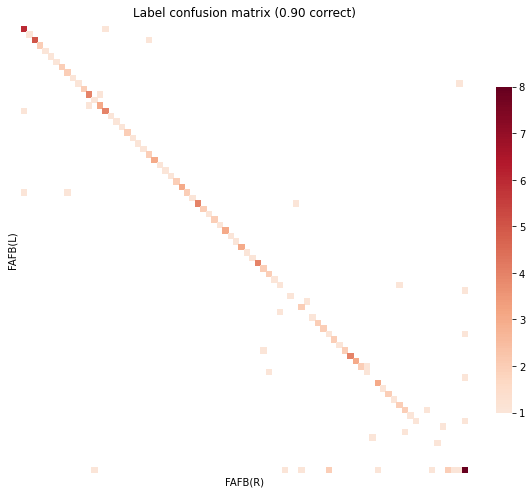

In [144]:
gen_result(res)

# GOAT no prior, barycenter init, matching just intra

In [147]:
options = {'maximize':True, 'maxiter':100, 'shuffle_input':True,'tol':1e-6,'reg':300}
res = max([quadratic_assignment_ot(dataset1_intra_pad, dataset2_intra, options=options)
                   for k in range(50)], key=lambda x: x.fun)

objective function value: 6198.336414141535
Matching Accuracy ignoring unknowns 0.95


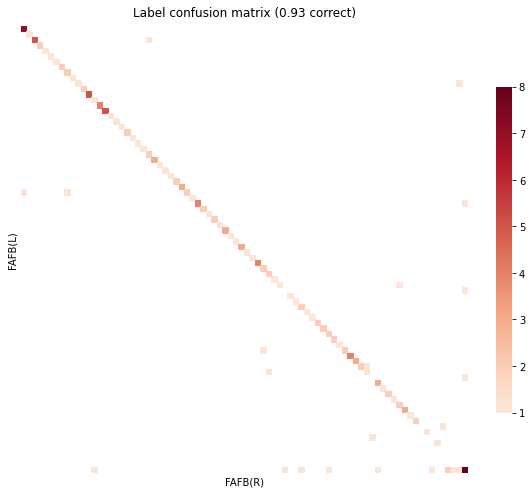

In [148]:
gen_result(res)

# still no prior, using inter-hemisphere info to make a "better" init

In [173]:
from ot import sinkhorn
sim = np.zeros((n,n))
sim[:len(dataset1_intra), :] = dataset1_to_dataset2 + dataset2_to_dataset1.T
power = -1
reg = 100
lamb = reg / np.max(np.abs(sim))
ones = np.ones(n)
sim = sinkhorn(ones, ones, sim, power/lamb, stopInnerThr=1e-4,numItermax=1000)


In [186]:
from scipy.optimize import linear_sum_assignment
s = np.zeros((n,n))
s[:len(dataset1_intra), :] = dataset1_to_dataset2 + dataset2_to_dataset1.T
row, col = linear_sum_assignment(s, maximize = True)

## GM

In [187]:
options = {'maximize':True, 'maxiter':100, 'shuffle_input':False,'tol':1e-6,'P0':sim}
res = max([quadratic_assignment(dataset1_intra_pad, dataset2_intra, options=options)
                   for k in range(50)], key=lambda x: x.fun)

objective function value: 6235.083554444008
Matching Accuracy ignoring unknowns 0.97


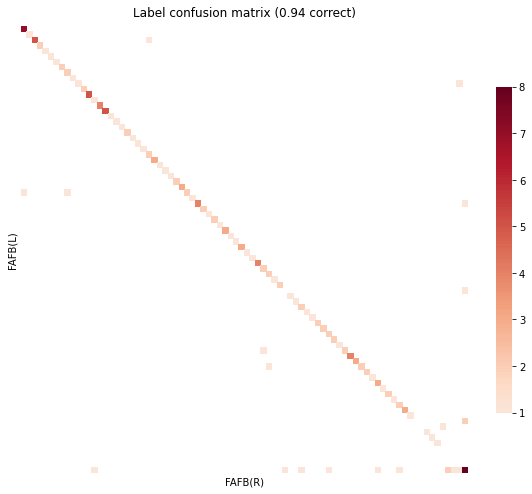

In [188]:
gen_result(res)

## GOAT

In [189]:
options = {'maximize':True, 'maxiter':100, 'shuffle_input':True,'tol':1e-6,'reg':300, 'P0':sim}
res = max([quadratic_assignment_ot(dataset1_intra_pad, dataset2_intra, options=options)
                   for k in range(50)], key=lambda x: x.fun)


objective function value: 6207.4674251068145
Matching Accuracy ignoring unknowns 0.97


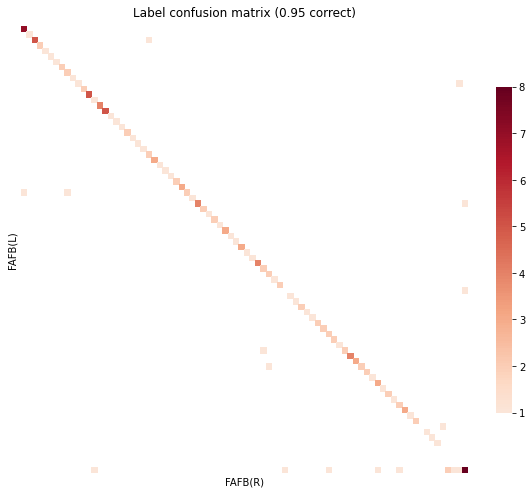

In [190]:
gen_result(res)

# GM augmented with inter-connection similarity matrix

In [219]:
from graspologic.match import GraphMatch
gmp = GraphMatch(n_init =50, max_iter = 100, eps=1e-5)
a = np.linalg.norm(dataset1_intra_pad) * np.linalg.norm(dataset2_intra)
b = np.linalg.norm(s)
gmp = gmp.fit(dataset1_intra_pad, dataset2_intra,S=s * (a/b))

objective function value: 6162.901828036416
Matching Accuracy ignoring unknowns 0.97


<AxesSubplot:title={'center':'Label confusion matrix (0.94 correct)'}, xlabel='FAFB(R)', ylabel='FAFB(L)'>

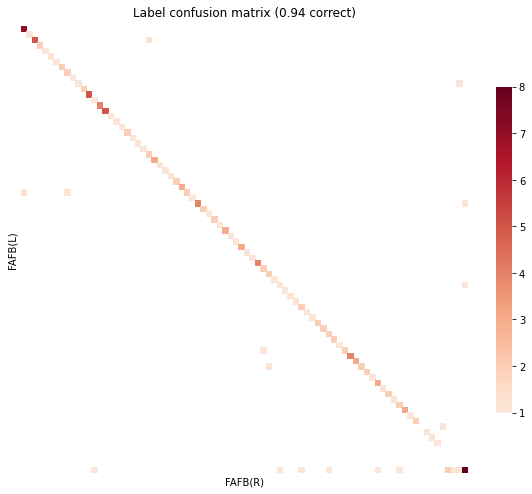

In [220]:
perm_inds = gmp.perm_inds_
print(f'objective function value: {np.sum(dataset1_intra_pad * dataset2_intra[perm_inds][:, perm_inds])}')
dataset2_intra_matched = dataset2_intra[perm_inds][:, perm_inds][: len(dataset1_ids)]
dataset2_meta_matched = dataset2_meta.iloc[perm_inds][: len(dataset1_ids)]

labels1 = dataset1_meta["label"]
dataset1_vmax = labels1.value_counts()[1:].max()
labels2 = dataset2_meta_matched["label"]
dataset2_vmax = labels2.value_counts()[1:].max()
vmax = max(dataset1_vmax, dataset2_vmax)

unique_labels = np.unique(list(labels1) + list(labels2))
conf_mat = confusion_matrix(labels1, labels2, labels=unique_labels, normalize=None)
conf_mat = pd.DataFrame(data=conf_mat, index=unique_labels, columns=unique_labels)
conf_mat = conf_mat.iloc[:-5, :-5]  # hack to ignore anything "unclear"
on_diag = np.trace(conf_mat.values) / np.sum(conf_mat.values)
print(f"Matching Accuracy ignoring unknowns {on_diag:.2f}")
confusionplot(
        labels1,
        labels2,
        ylabel=datasets[0],
        xlabel=datasets[1],
        title="Label confusion matrix",
        annot=False,
        vmax=vmax,
        xticklabels=False,
        yticklabels=False,
    )